# Analyze SARS-CoV-2 Strain B.1.1.7
[Work in progress]

This notebook queries the Knowledge Graph for Strains with the B.1.1.7 lineage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator, WeekdayLocator
import seaborn as sns
from py2neo import Graph

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

##### Connect to COVID-19-Community Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

##### Utility Methods

In [4]:
def transform_data(df, region):
    # calculate cummulatve sum
    df['total'] = df.groupby([region])['count'].cumsum()
    
    # pivot table
    df = pd.DataFrame(df.pivot(index='collectionDate', columns=region, values='total').to_records())
    df.fillna(method='ffill', inplace=True)
    
    # convert neo4j date to date
    df['collectionDate'] = df['collectionDate'].astype(str)
    df['collectionDate'] = pd.to_datetime(df['collectionDate'], infer_datetime_format=False)
    df.set_index('collectionDate', inplace=True)
    
    return df

In [5]:
def plot_time_series(df, title):
    plt.figure(figsize=(16, 10))
    ax = sns.lineplot(data=df);
    ax.set_title(title)
    ax.set_xlabel('Collection Date')
    ax.set_ylabel('Number of Strains')
    ax.set_yscale('log');
    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_minor_locator(WeekdayLocator())
    ax.tick_params(which='major', length=12)
    ax.tick_params(which='minor', length=8)
    ax.xaxis.grid(True, which='minor')
    ax.grid(True)

## Get Number of B.1.1.7 Strains

In [6]:
lineage = 'B.1.1.7'
taxonomy_id = 'taxonomy:2697049' # SARS-CoV-2

In [7]:
query = """
MATCH (s:Strain)
WHERE s.lineage = $lineage AND s.taxonomyId = $taxonomy_id
RETURN count(s) AS count
"""
n_strains = graph.evaluate(query, lineage=lineage, taxonomy_id=taxonomy_id)

In [8]:
print('Number of B.1.1.7 strains:', n_strains)

Number of B.1.1.7 strains: 4638


## Strain B.1.1.7 Time Series by Country

In [28]:
query = """
// aggregate data to the country level (City->Admin2->Admin1->County): max 3 hops
MATCH (s:Strain)-[:FOUND_IN]->(:Location)-[:IN*0..3]->(c:Country)
WHERE s.lineage = $lineage AND s.taxonomyId = $taxonomy_id
      AND s.collectionDate > date('2020-02-01') // remove strain with invalid collection date
RETURN DISTINCT(s.collectionDate) AS collectionDate, c.name AS country, count(s) AS count
ORDER BY collectionDate
"""
df_country = graph.run(query, lineage=lineage, taxonomy_id=taxonomy_id).to_data_frame()

In [29]:
df_country = transform_data(df_country, 'country')

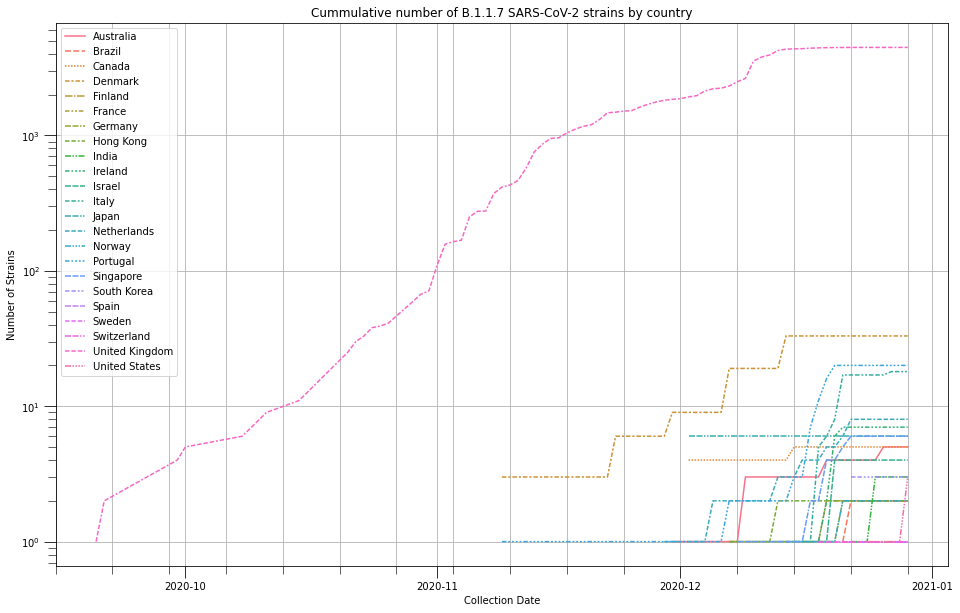

In [30]:
plot_time_series(df_country, f'Cummulative number of {lineage} SARS-CoV-2 strains by country')

### Strain B.1.1.7 Time Series by State
Note, data reported at the country level will not be included here.

In [25]:
query = """
// aggregate data to the state (Admin1) level: (City->Admin2->Admin1): max 2 hops
MATCH (s:Strain)-[:FOUND_IN]->(:Location)-[:IN*0..2]->(a:Admin1)-[:IN]->(c:Country)
WHERE s.lineage = $lineage AND s.taxonomyId = $taxonomy_id 
      AND s.collectionDate > date('2020-02-01') // remove strain with invalid collection date
RETURN DISTINCT(s.collectionDate) AS collectionDate, c.iso3 + '-' + a.name AS state, a.name, c.name, count(s) AS count
ORDER BY collectionDate
"""
df_state = graph.run(query, lineage=lineage, taxonomy_id=taxonomy_id).to_data_frame()

In [26]:
df_state = transform_data(df_state, 'state')

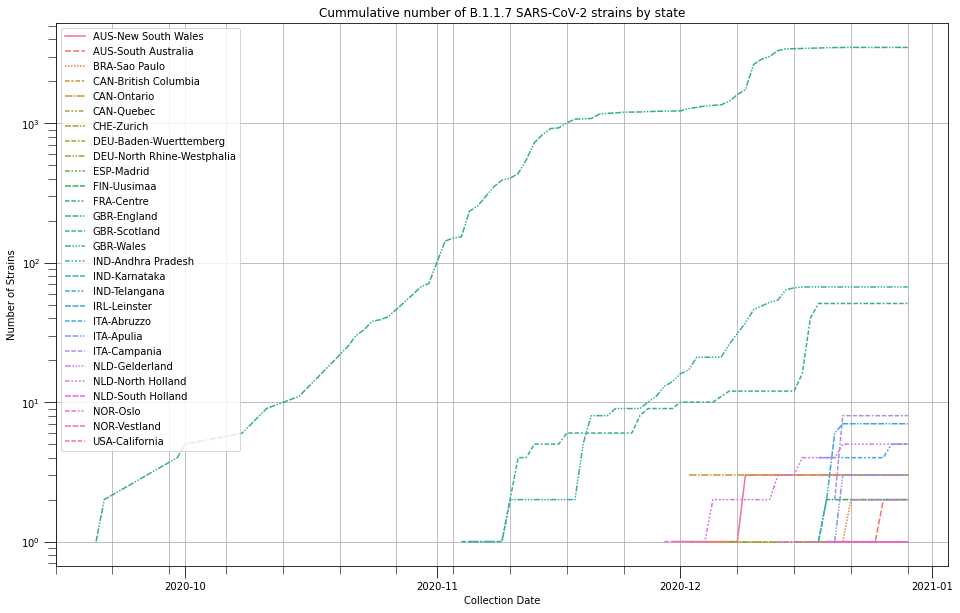

In [27]:
plot_time_series(df_state, f'Cummulative number of {lineage} SARS-CoV-2 strains by state')

## Strain B.1.1.7 Variant Frequencies

In [15]:
query = """
MATCH (s:Strain)-[:HAS_VARIANT]->(v:Variant)
WHERE s.lineage = $lineage AND s.taxonomyId = $taxonomy_id
RETURN DISTINCT(v.geneVariant) AS geneVariant, split(v.geneVariant, ':')[0] AS gene,
       v.proteinVariant AS proteinVariant, toString(v.proteinPosition) as proteinPosition, 
       v.variantConsequence AS variantConsequense, v.variantType AS variantType, 
       v.start AS start, count(s) AS count
ORDER BY count DESC, start ASC
"""
df_var = graph.run(query, lineage=lineage, taxonomy_id=taxonomy_id).to_data_frame()

In [16]:
df_var['frequency'] = df_var['count'] / n_strains

In [17]:
# TODO add menu: gene, proteinPosition, variantConsequence, variantType

In [18]:
df_var.head(30)

,geneVariant,gene,proteinVariant,proteinPosition,variantConsequense,variantType,start,count,frequency
0,ORF1ab,ORF1ab,QHD43415.1,None,upstream_gene_variant,SNP,241,3771,0.813066
1,ORF1ab:c.2772ttC>ttT,ORF1ab,QHD43415.1:p.924F,924,synonymous_variant,SNP,3037,3771,0.813066
2,ORF1ab:c.14144cCt>cTt,ORF1ab,QHD43415.1:p.4715P>L,4715,missense_variant,SNP,14408,3771,0.813066
3,S:c.1841gAt>gGt,S,QHD43416.1:p.614D>G,614,missense_variant,SNP,23403,3771,0.813066
4,S:c.3352Gac>Cac,S,QHD43416.1:p.1118D>H,1118,missense_variant,SNP,24914,3771,0.813066
5,ORF8:c.218tAc>tGc,ORF8,QHD43422.1:p.73Y>C,73,missense_variant,SNP,28111,3771,0.813066
6,ORF1ab:c.3002aCt>aTt,ORF1ab,QHD43415.1:p.1001T>I,1001,missense_variant,SNP,3267,3770,0.812850
7,ORF1ab:c.5123gCt>gAt,ORF1ab,QHD43415.1:p.1708A>D,1708,missense_variant,SNP,5388,3770,0.812850
8,ORF1ab:c.6689aTa>aCa,ORF1ab,QHD43415.1:p.2230I>T,2230,missense_variant,SNP,6954,3770,0.812850
9,ORF1ab:c.14412ccC>ccT,ORF1ab,QHD43415.1:p.4804P,4804,synonymous_variant,SNP,14676,3770,0.812850
